In [1]:
#getting source file and creating creating week vise excel files with rfm score get cluster and segmentation

import glob
import pandas as pd
import os
import warnings
warnings.simplefilter("ignore")


# Set the paths for the input and output folders
input_folder = "C:/Users/GCV/Documents/MAS/Project AR/input_test/"
output_folder = "C:/Users/GCV/Documents/MAS/Project AR/output_test/"

# Set the path of the folder you want to get file names from
folder_path = "C:/Users/GCV/Documents/MAS/Project AR/input_test/"

# Set the file pattern you want to match, for example, all files with ".txt" extension

file_pattern_xlsx = folder_path + "*.xlsx"
file_pattern_xls = folder_path + "*.xls"
file_pattern_xlsm = folder_path + "*.xlsm"

# Use glob function to get the file names that match each file pattern
file_names_xlsx = glob.glob(file_pattern_xlsx)
file_names_xls = glob.glob(file_pattern_xls)
file_names_xlsm = glob.glob(file_pattern_xlsm)


# Loop through each file name and process the corresponding Excel file
for file_name in file_names_xlsx:
        # Read the Excel file into a pandas DataFrame
        df = pd.read_excel(file_name,sheet_name='Breakdown External ')

        #creating cp pivot table
        pivot_table_cp = pd.pivot_table(df, values='CP',index=['Customer Name'] , aggfunc = 'max')
       
    
        # Get a boolean mask of the columns that contain "Amount"
        # mask = df.columns.str.contains("Amount")
        # df.loc[:, mask] = df.loc[:, mask].rename(columns=lambda x: x.replace("Amount", "Amount in USD"))

        
        #rename some changeable column names into a unique name
        if 'Amount' in df.columns:
            df = df.rename(columns={'Amount': 'Amount in USD'})
        elif 'Amount in local currency' in df.columns:
            df = df.rename(columns={'Amount in local currency': 'Amount in USD'})
        elif "Ageing as at 27th October'22" in df.columns:
            df = df.rename(columns={"Ageing as at 27th October'22": 'Ageing'})
        
            
        #convert 'Amount in USD' column's data type into numeric
        df['Amount in USD'] = pd.to_numeric(df['Amount in USD'], errors='coerce')
        #creating ageing pivot table
        pivot_table_ageing = pd.pivot_table(df, values='Amount in USD',index=['Customer Name'] , columns=['Ageing'], aggfunc = 'sum')

        #filling null values with zeros
        pivot_table_ageing = pivot_table_ageing.fillna(0)

        #concat 2 pivot tables 
        summary_df=pd.concat([pivot_table_ageing, pivot_table_cp['CP']], axis=1)

        #removing negative values in data frame
        summary_df = summary_df.applymap(lambda x: max(0, x))

        summary_df['Customer Name'] = summary_df.index
        summary_df = summary_df.reset_index(drop=True)
       
        #some column name has 0-30 Days so remove Days from name
        summary_df.columns = summary_df.columns.str.replace(' Days', '')

        if 'Above 120' in summary_df.columns:
            summary_df = summary_df.rename(columns={'Above 120': '120 Above'})

        summary_subset1 = summary_df[['CP', '0-30', '31-45', '46-60','61-90','91-120','120 Above']]
        summary_subset2 = summary_df[['Customer Name']]
        def replace_values(row):
            if row['CP'] > 30:
                row['0-30'] = 0
            if row['CP'] > 45:
                row['31-45'] = 0
            if row['CP'] > 60:
                row['46-60'] = 0
            if row['CP'] > 90:
                row['61-90'] = 0
            if row['CP'] > 120:
                row['91-120'] = 0
            if row['CP'] > 120:
                row['120 Above'] = 0

            return row

        # apply the function to each row of the data frame
        summary_subset1 = summary_subset1.apply(replace_values, axis=1)
        summary_df = pd.concat([summary_subset2,summary_subset1],axis=1)
        
        #calculating frequency
        # define a custom function to count the number of values greater than 0 in a list
        def freq(lst):
            return sum([1 for x in lst if x > 0])
        # create new subsets of the DataFrame using .loc
        df_subset4 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above']]
        df_subset6 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above']]
        df_subset5 = summary_df.loc[:, ['Customer Name', 'CP']]

        # create new columns using .loc and avoid chained indexing
        df_subset4.loc[:, 'F'] = df_subset4.apply(lambda row: freq(row.tolist()), axis=1)
        df_subset6.loc[:, 'RowSum'] = df_subset6.sum(axis=1)
        df_subset4.loc[:, 'M'] = df_subset6.loc[:, 'RowSum']

        # concatenate the subsets into a new DataFrame
        summary_df = pd.concat([df_subset5, df_subset4], axis=1)


        df_subset7 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above','M']]
        df_subset8 = summary_df.loc[:, ['Customer Name', 'CP','F']]

        def calc_R(row):
            # Calculate the divisor (total value for the row)
            total = row['M']
            # Calculate the weights and apply to the values in the row
            if total == 0:
                return None
            else:
                weights = [0.083333333, 2.5, 3.75, 5, 7.5, 10]
                values = [row['0-30'], row['31-45'], row['46-60'], row['61-90'], row['91-120'], row['120 Above']]
                weighted_values = [value * weight / total for value, weight in zip(values, weights)]
                # Sum the weighted values to get the final R value
                return sum(weighted_values)

        # Apply the custom function to each row and store the result in a new column 'R'
        df_subset7['R'] = df_subset7.apply(calc_R, axis=1)
        df_subset7.head()
        summary_df = pd.concat([df_subset8, df_subset7], axis=1)
        summary_df=summary_df.fillna(0)
        summary_df = summary_df[['Customer Name', 'CP' , '0-30', '31-45', '46-60', '61-90',
               '91-120', '120 Above', 'R', 'F','M']]
        nature_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\Automation\Nature.xlsx')
            #left join on both data frame
        merged_df = pd.merge(summary_df ,nature_df ,on="Customer Name", how="left") #both column name of customer shoul be same if not remane both column as customer
        merged_df["nature of the business"].fillna(0, inplace=True)
        summary_df['N'] = merged_df["nature of the business"]
        #drop rows where N and M column vlaues 0
        mask1 = summary_df['N'] != 0 
        summary_df = summary_df[mask1]
        mask2 = summary_df['M'] != 0
        summary_df = summary_df[mask2]

        summary_df =summary_df.reset_index(drop=True)

        final_df = summary_df[['Customer Name','R','F','M','N']]
        #final_df.to_excel('W16.xlsx',index=False)

        # Construct the output file name based on the input file name
        output_file_name = os.path.join(output_folder, os.path.basename(file_name))
        output_file_name = os.path.splitext(output_file_name)[0] + ".xlsx"
        # Write the processed DataFrame to the output file
        final_df.to_excel(output_file_name, index=False)

        
        
# Loop through each file name and process the corresponding Excel file
for file_name in file_names_xls:
        # Read the Excel file into a pandas DataFrame
        df = pd.read_excel(file_name,sheet_name='Breakdown External ')

        #creating cp pivot table
        pivot_table_cp = pd.pivot_table(df, values='CP',index=['Customer Name'] , aggfunc = 'max')
       
    
        # Get a boolean mask of the columns that contain "Amount"
        # mask = df.columns.str.contains("Amount")
        # df.loc[:, mask] = df.loc[:, mask].rename(columns=lambda x: x.replace("Amount", "Amount in USD"))

        
        #rename some changeable column names into a unique name
        if 'Amount' in df.columns:
            df = df.rename(columns={'Amount': 'Amount in USD'})
        elif 'Amount in local currency' in df.columns:
            df = df.rename(columns={'Amount in local currency': 'Amount in USD'})
        elif "Ageing as at 27th October'22" in df.columns:
            df = df.rename(columns={"Ageing as at 27th October'22": 'Ageing'})
        
            
        #convert 'Amount in USD' column's data type into numeric
        df['Amount in USD'] = pd.to_numeric(df['Amount in USD'], errors='coerce')
        #creating ageing pivot table
        pivot_table_ageing = pd.pivot_table(df, values='Amount in USD',index=['Customer Name'] , columns=['Ageing'], aggfunc = 'sum')

        #filling null values with zeros
        pivot_table_ageing = pivot_table_ageing.fillna(0)

        #concat 2 pivot tables 
        summary_df=pd.concat([pivot_table_ageing, pivot_table_cp['CP']], axis=1)

        #removing negative values in data frame
        summary_df = summary_df.applymap(lambda x: max(0, x))

        summary_df['Customer Name'] = summary_df.index
        summary_df = summary_df.reset_index(drop=True)
       
        #some column name has 0-30 Days so remove Days from name
        summary_df.columns = summary_df.columns.str.replace(' Days', '')

        if 'Above 120' in summary_df.columns:
            summary_df = summary_df.rename(columns={'Above 120': '120 Above'})

        summary_subset1 = summary_df[['CP', '0-30', '31-45', '46-60','61-90','91-120','120 Above']]
        summary_subset2 = summary_df[['Customer Name']]
        def replace_values(row):
            if row['CP'] > 30:
                row['0-30'] = 0
            if row['CP'] > 45:
                row['31-45'] = 0
            if row['CP'] > 60:
                row['46-60'] = 0
            if row['CP'] > 90:
                row['61-90'] = 0
            if row['CP'] > 120:
                row['91-120'] = 0
            if row['CP'] > 120:
                row['120 Above'] = 0

            return row

        # apply the function to each row of the data frame
        summary_subset1 = summary_subset1.apply(replace_values, axis=1)
        summary_df = pd.concat([summary_subset2,summary_subset1],axis=1)

        
        
        #calculating frequency
        # define a custom function to count the number of values greater than 0 in a list
        def freq(lst):
            return sum([1 for x in lst if x > 0])
       
    
    
        # create new subsets of the DataFrame using .loc
        df_subset4 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above']]
        df_subset6 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above']]
        df_subset5 = summary_df.loc[:, ['Customer Name', 'CP']]

        # create new columns using .loc and avoid chained indexing
        df_subset4.loc[:, 'F'] = df_subset4.apply(lambda row: freq(row.tolist()), axis=1)
        df_subset6.loc[:, 'RowSum'] = df_subset6.sum(axis=1)
        df_subset4.loc[:, 'M'] = df_subset6.loc[:, 'RowSum']

        # concatenate the subsets into a new DataFrame
        summary_df = pd.concat([df_subset5, df_subset4], axis=1)


        df_subset7 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above','M']]
        df_subset8 = summary_df.loc[:, ['Customer Name', 'CP','F']]

        def calc_R(row):
            # Calculate the divisor (total value for the row)
            total = row['M']
            # Calculate the weights and apply to the values in the row
            if total == 0:
                return None
            else:
                weights = [0.083333333, 2.5, 3.75, 5, 7.5, 10]
                values = [row['0-30'], row['31-45'], row['46-60'], row['61-90'], row['91-120'], row['120 Above']]
                weighted_values = [value * weight / total for value, weight in zip(values, weights)]
                # Sum the weighted values to get the final R value
                return sum(weighted_values)

        # Apply the custom function to each row and store the result in a new column 'R'
        df_subset7['R'] = df_subset7.apply(calc_R, axis=1)
        df_subset7.head()
        summary_df = pd.concat([df_subset8, df_subset7], axis=1)
        summary_df=summary_df.fillna(0)
        summary_df = summary_df[['Customer Name', 'CP' , '0-30', '31-45', '46-60', '61-90',
               '91-120', '120 Above', 'R', 'F','M']]
        nature_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\Automation\Nature.xlsx')
            #left join on both data frame
        merged_df = pd.merge(summary_df ,nature_df ,on="Customer Name", how="left") #both column name of customer shoul be same if not remane both column as customer
        merged_df["nature of the business"].fillna(0, inplace=True)
        summary_df['N'] = merged_df["nature of the business"]
        #drop rows where N and M column vlaues 0
        mask1 = summary_df['N'] != 0 
        summary_df = summary_df[mask1]
        mask2 = summary_df['M'] != 0
        summary_df = summary_df[mask2]

        summary_df =summary_df.reset_index(drop=True)

        final_df = summary_df[['Customer Name','R','F','M','N']]
        #final_df.to_excel('W16.xlsx',index=False)

        # Construct the output file name based on the input file name
        output_file_name = os.path.join(output_folder, os.path.basename(file_name))
        output_file_name = os.path.splitext(output_file_name)[0] + ".xlsx"
        # Write the processed DataFrame to the output file
        final_df.to_excel(output_file_name, index=False)


        

        
# Loop through each file name and process the corresponding Excel file
for file_name in file_names_xlsm:
        # Read the Excel file into a pandas DataFrame
        df = pd.read_excel(file_name,sheet_name='Breakdown External ')

        #creating cp pivot table
        pivot_table_cp = pd.pivot_table(df, values='CP',index=['Customer Name'] , aggfunc = 'max')
       
    
        # Get a boolean mask of the columns that contain "Amount"
        # mask = df.columns.str.contains("Amount")
        # df.loc[:, mask] = df.loc[:, mask].rename(columns=lambda x: x.replace("Amount", "Amount in USD"))

        
        #rename some changeable column names into a unique name
        if 'Amount' in df.columns:
            df = df.rename(columns={'Amount': 'Amount in USD'})
        elif 'Amount in local currency' in df.columns:
            df = df.rename(columns={'Amount in local currency': 'Amount in USD'})
#         elif "Ageing as at 27th October'22" in df.columns:
#             df = df.rename(columns={"Ageing as at 27th October'22": 'Ageing'})
        
            
        #convert 'Amount in USD' column's data type into numeric
        df['Amount in USD'] = pd.to_numeric(df['Amount in USD'], errors='coerce')
        #creating ageing pivot table
        pivot_table_ageing = pd.pivot_table(df, values='Amount in USD',index=['Customer Name'] , columns=['Ageing'], aggfunc = 'sum')

        #filling null values with zeros
        pivot_table_ageing = pivot_table_ageing.fillna(0)

        #concat 2 pivot tables 
        summary_df=pd.concat([pivot_table_ageing, pivot_table_cp['CP']], axis=1)

        #removing negative values in data frame
        summary_df = summary_df.applymap(lambda x: max(0, x))

        summary_df['Customer Name'] = summary_df.index
        summary_df = summary_df.reset_index(drop=True)
       
        #some column name has 0-30 Days so remove Days from name
        summary_df.columns = summary_df.columns.str.replace(' Days', '')

        if 'Above 120' in summary_df.columns:
            summary_df = summary_df.rename(columns={'Above 120': '120 Above'})


        summary_subset1 = summary_df[['CP', '0-30', '31-45', '46-60','61-90','91-120','120 Above']]
        summary_subset2 = summary_df[['Customer Name']]
        def replace_values(row):
            if row['CP'] > 30:
                row['0-30'] = 0
            if row['CP'] > 45:
                row['31-45'] = 0
            if row['CP'] > 60:
                row['46-60'] = 0
            if row['CP'] > 90:
                row['61-90'] = 0
            if row['CP'] > 120:
                row['91-120'] = 0
            if row['CP'] > 120:
                row['120 Above'] = 0

            return row

        # apply the function to each row of the data frame
        summary_subset1 = summary_subset1.apply(replace_values, axis=1)
        summary_df = pd.concat([summary_subset2,summary_subset1],axis=1)

        #calculating frequency
        # define a custom function to count the number of values greater than 0 in a list
        def freq(lst):
            return sum([1 for x in lst if x > 0])
        # create new subsets of the DataFrame using .loc
        df_subset4 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above']]
        df_subset6 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above']]
        df_subset5 = summary_df.loc[:, ['Customer Name', 'CP']]

        # create new columns using .loc and avoid chained indexing
        df_subset4.loc[:, 'F'] = df_subset4.apply(lambda row: freq(row.tolist()), axis=1)
        df_subset6.loc[:, 'RowSum'] = df_subset6.sum(axis=1)
        df_subset4.loc[:, 'M'] = df_subset6.loc[:, 'RowSum']

        # concatenate the subsets into a new DataFrame
        summary_df = pd.concat([df_subset5, df_subset4], axis=1)


        df_subset7 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above','M']]
        df_subset8 = summary_df.loc[:, ['Customer Name', 'CP','F']]

        def calc_R(row):
            # Calculate the divisor (total value for the row)
            total = row['M']
            # Calculate the weights and apply to the values in the row
            if total == 0:
                return None
            else:
                weights = [0.083333333, 2.5, 3.75, 5, 7.5, 10]
                values = [row['0-30'], row['31-45'], row['46-60'], row['61-90'], row['91-120'], row['120 Above']]
                weighted_values = [value * weight / total for value, weight in zip(values, weights)]
                # Sum the weighted values to get the final R value
                return sum(weighted_values)

        # Apply the custom function to each row and store the result in a new column 'R'
        df_subset7['R'] = df_subset7.apply(calc_R, axis=1)
        df_subset7.head()
        summary_df = pd.concat([df_subset8, df_subset7], axis=1)
        summary_df=summary_df.fillna(0)
        summary_df = summary_df[['Customer Name', 'CP' , '0-30', '31-45', '46-60', '61-90',
               '91-120', '120 Above', 'R', 'F','M']]
        nature_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\Automation\Nature.xlsx')
            #left join on both data frame
        merged_df = pd.merge(summary_df ,nature_df ,on="Customer Name", how="left") #both column name of customer shoul be same if not remane both column as customer
        merged_df["nature of the business"].fillna(0, inplace=True)
        summary_df['N'] = merged_df["nature of the business"]
        #drop rows where N and M column vlaues 0
        mask1 = summary_df['N'] != 0 
        summary_df = summary_df[mask1]
        mask2 = summary_df['M'] != 0
        summary_df = summary_df[mask2]

        summary_df =summary_df.reset_index(drop=True)

        final_df = summary_df[['Customer Name','R','F','M','N']]

        # Construct the output file name based on the input file name
        output_file_name = os.path.join(output_folder, os.path.basename(file_name))
        output_file_name = os.path.splitext(output_file_name)[0] + ".xlsx"
        # Write the processed DataFrame to the output file
        final_df.to_excel(output_file_name, index=False)

        

print("done")
        

done


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
import re


In [3]:


# Set the paths for the input and output folders
input_folder = "C:/Users/GCV/Documents/MAS/Project AR/output_test/"
output_folder = "C:/Users/GCV/Documents/MAS/Project AR/2nd_output/"




# Set the path of the folder you want to get file names from
folder_path = "C:/Users/GCV/Documents/MAS/Project AR/output_test/"

# Set the file pattern you want to match, for example, all files with ".txt" extension

file_pattern_xlsx = folder_path + "*.xlsx"

# Use glob function to get the file names that match each file pattern
file_names_xlsx = glob.glob(file_pattern_xlsx)



# Loop through each file name and process the corresponding Excel file


for file_name in file_names_xlsx:
    
        rfm_df = pd.read_excel(file_name)
        #print(rfm_df)
        #print(file_name)
        
        rfm_df['R_rank'] = rfm_df['R'].rank(ascending=True)
        rfm_df['F_rank'] = rfm_df['F'].rank(ascending=True)
        rfm_df['M_rank'] = rfm_df['M'].rank(ascending=True)
        rfm_df['N_rank'] = rfm_df['N'].rank(ascending=True)
        
         # normalizing the rank of the customers
        rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
        rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
        rfm_df['M_rank_norm'] = (rfm_df['M_rank']/rfm_df['M_rank'].max())*100
        rfm_df['N_rank_norm'] = (rfm_df['N_rank']/rfm_df['N_rank'].max())*100

        rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank','N_rank'], inplace=True)

        #print('Normalized --------------------------------------------------------------------------------: ',rfm_df)
        
        rfm_df['RFM_Score'] = 0.25*rfm_df['R_rank_norm']+0.25 *rfm_df['F_rank_norm']+0.25*rfm_df['M_rank_norm']+0.25*rfm_df['R_rank_norm']
        rfm_df['RFM_Score'] *= 0.05
        #rfm_df = rfm_df.round(2)
        output = rfm_df
        #print(rfm_df[['Customer', 'RFM_Score']])
        
        rfm_df["Customer_segment"] =np.where(rfm_df['RFM_Score'] >3.5, "High Overdue - RFM>3.5",
                                    (np.where(rfm_df['RFM_Score'] > 2,"Moderate Overdue - 2<RFM<3.5",
                                    np.where(rfm_df['RFM_Score'] > 1,'Less Overdue - 1<RFM<2', 'VeryLess Overdue - RFM<1'))))
        
        rfm_df["Customer_segment1"] =np.where(rfm_df['RFM_Score'] >3.5, "4",
                                    (np.where(rfm_df['RFM_Score'] > 2,"3",
                                    np.where(rfm_df['RFM_Score'] > 1,'2', '1'))))
        
        #print(rfm_df[['Customer Name', 'RFM_Score', 'Customer_segment','Customer_segment1','M']])
        output = rfm_df
        
        
        char = file_name.split('W')[1].split('.')[0]
    
        
         #match = re.search(r'W(\d+)\.(xlsx|xlsm|xls)', os.path.basename(file_name))
        
                
        submission = pd.DataFrame({
        "Customer": output["Customer Name"],
        "RFM_Score": output["RFM_Score"],
        "Customer_segment": output["Customer_segment"],
        #"Week":'W' + str(re.search(r'W(\d+)\.xlsx', os.path.basename(file_name)).group(1)),
        "Week":'W' +  str(char),
        "Cluster": output['Customer_segment1'],
        "Monetory":output['M']
        })
        
        
        
        #print(char)
        
        output_file_name = os.path.join(output_folder, os.path.basename(file_name))
        output_file_name = os.path.splitext(output_file_name)[0] + "output.xlsx"
        
        
        submission = submission.replace('Week ', 'W', regex=True)
        #print(submission.head(3))
        
        submission.to_excel(output_file_name, index=False)
        submission1 = pd.read_excel(output_file_name)
        #print(submission1.head(5))

        
print("done")
        
      
        

done


In [4]:
import pandas as pd
import os

input_file_path = r"C:/Users/GCV/Documents/MAS/Project AR/2nd_output/"
output_file_path = r"C:/Users/GCV/Documents/MAS/Project AR/2nd_final_output/"

#create a list to store all the file references of the input folder using the listdir function from the os library.
#To see the contents of a library (like the listdir function, you can use the dir function on the library name).
#Use dir(library_name) to list contents

excel_file_list = os.listdir(input_file_path)

#print all the files stored in the folder, after defining the list
excel_file_list


#Once each file opens, use the append function to start consolidating the data stored in multiple files

#create a new, blank dataframe, to handle the excel file imports
df = pd.DataFrame()

#Run a for loop to loop through each file in the list
for excel_files in excel_file_list:
 #check for .xlsx suffix files only
 if excel_files.endswith((".xlsx", ".xls", ".xlsm")):
 #create a new dataframe to read/open each Excel file from the list of files created above
    df1 = pd.read_excel(input_file_path + excel_files)
     #print(df1.head())
        
     #append each file into the original empty dataframe
    df= pd.concat([df, df1], ignore_index=True)
        
#print(df.head())
df['Customer'] = df['Customer'].str.replace('AMAZON ESSENTIAL / SPOTTED ZEBRA', 'AMAZON ESSENTIAL - SPOTTED ZEBRA')

#transfer final output to an Excel (xlsx) file on the output path 
df.to_excel(output_file_path+"Consolidated_file.xlsx")

print(df.tail())

                             Customer  RFM_Score  \
1129                 PVH ASIA LIMITED   2.893519   
1130                Puritas (Pvt) Ltd   3.449074   
1131                 Summersalt, Inc.   4.097222   
1132  The Colombo Fashion WSwim Pvt L   3.032407   
1133                 prAna Living LLC   2.384798   

                  Customer_segment Week  Cluster    Monetory  
1129  Moderate Overdue - 2<RFM<3.5  W51        3      695.00  
1130  Moderate Overdue - 2<RFM<3.5  W51        3    43303.53  
1131        High Overdue - RFM>3.5  W51        4  4965824.19  
1132  Moderate Overdue - 2<RFM<3.5  W51        3     2781.20  
1133  Moderate Overdue - 2<RFM<3.5  W51        3   542572.21  


In [5]:
#change week oder

df = pd.read_excel( r"C:/Users/GCV/Documents/MAS/Project AR/2nd_final_output/Consolidated_file.xlsx")

mask1 = df['Week'].isin(['W1', 'W2', 'W3', 'W4', 'W5'])

new_df1 = df.loc[mask1, :]

#mask2 =  ~(df['Week'].isin(['W1', 'W2', 'W3', 'W4', 'W5']))
mask2 =  ~(mask1)

new_df2 = df.loc[mask2, :]

df= pd.concat([new_df2, new_df1], ignore_index=True)
df= df.reset_index(drop=True)
df = df.drop(['Unnamed: 0'], axis = 1)

df.to_excel(r"C:/Users/GCV/Documents/MAS/Project AR/2nd_final_output/Consolidated_file_sorted.xlsx")
df.head()

,Customer,RFM_Score,Customer_segment,Week,Cluster,Monetory
0,AMAZON ESSENTIAL - SPOTTED ZEBRA,3.108757,Moderate Overdue - 2<RFM<3.5,W16,3,11178.00
1,"AMERICAN DESIGNER FASHION, S.A",2.112688,Moderate Overdue - 2<RFM<3.5,W16,3,14750.15
2,ASCO GENERAL SUPPLIES (FAR EAST)LTD,2.904967,Moderate Overdue - 2<RFM<3.5,W16,3,1503457.40
3,Abercrombie & Fitch Trading Co.,2.618711,Moderate Overdue - 2<RFM<3.5,W16,3,209184.39
4,Aerie,3.124307,Moderate Overdue - 2<RFM<3.5,W16,3,2364214.49


In [6]:
import pandas as pd

data = rfm_df[['Customer Name', 'RFM_Score', 'Customer_segment']]
data.to_excel('Output.xlsx', sheet_name='sheet1', index=False)

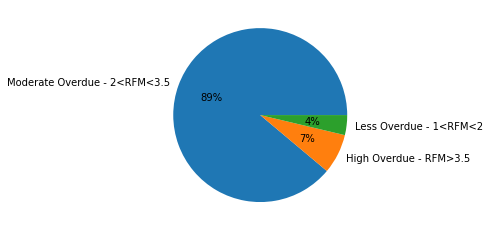

In [7]:
plt.pie(rfm_df.Customer_segment.value_counts(),
labels=rfm_df.Customer_segment.value_counts().index,
autopct='%.0f%%')
plt.show()

In [8]:
#got the consolidate excel file which include RFM score and cluster of customer by weeks 

In [9]:
#create separate excel for the each and every customer extracting week number monetary values and RFM score

In [10]:
import pandas as pd

# Read the input file
#consolidate_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\2nd_final_output\Consolidated_file.xlsx")
consolidate_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\2nd_final_output\Consolidated_file_sorted.xlsx')

# Get unique customer names
customer_names = consolidate_df["Customer"].unique()

# Iterate over each customer and create a separate Excel file
for customer in customer_names:
    # Filter the dataframe for the current customer
    #customer_df = consolidate_df[consolidate_df["Customer"] == customer][["RFM_Score", "Customer_segment", "Week", "Cluster","Monetory"]]
    customer_df1 = consolidate_df[consolidate_df["Customer"] == customer][[ "Week","RFM_Score"]]

    # Create output file name
    output_file_name = f"{customer}.xlsx"
    #output_folder = r"C:/Users/GCV/Documents/MAS/Project AR/con_output/"
    output_folder1 = r"C:/Users/GCV/Documents/MAS/Project AR/con_output/test/"
   
    #output_file_path = os.path.join(output_folder, output_file_name)
    output_file_path1 = os.path.join(output_folder1, output_file_name)

    #print(output_folder)
    #print(output_file_name)
    #print(output_file_path)

    # Save the filtered dataframe to a separate Excel file
    #customer_df.to_excel(output_file_path, index=False)
    
    
    #Remove customers who has low data points(when customer has low datapoints ES model occurs some errors)
    row_count  = customer_df1.shape[0]
    if row_count >20:
        customer_df1.to_excel(output_file_path1, index=False)


In [11]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from openpyxl import Workbook as wb
from itertools import cycle

import os
import numpy as np
import pandas as pd
import warnings
import seaborn as sns 
import matplotlib.pyplot as plt
import openpyxl


In [12]:
#put model into future_prediction function
def future_prediction(filename):
    # Load the input data from the excel file

    # Perform the time series modeling here

    %matplotlib inline 
    plt.style.use('bmh')
    sns.set_style("whitegrid")
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15) 
    warnings.filterwarnings("ignore")
    color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    
    #calculate smape
    def smape(a,f):
        return 1/len(a)*np.sum(2 * np.abs(f - a) / (np.abs(a)+ np.abs(f))*100)
    
    #read the file
    rfm_data=pd.read_excel(filename)
    rfm_data.head()
    #split data into train and test
    row_count  = rfm_data.shape[0]

    train_data = rfm_data.iloc[:(row_count-8)]
    test_data = rfm_data.iloc[(row_count-8):] 
    
    
    print(train_data)
    #getting predicting values
    span = 12
    alpha = 2/(span+1)

    simpleExpSmooth_model = SimpleExpSmoothing(train_data['RFM_Score']).fit(smoothing_level=alpha,optimized=True)
    doubleExpSmooth_model = ExponentialSmoothing(train_data['RFM_Score'],trend='add',seasonal_periods=6).fit()
    tripleExpSmooth_model = ExponentialSmoothing(train_data['RFM_Score'],trend='add',damped_trend=True,seasonal='add',seasonal_periods=6).fit()

    predictions_simpleExpSmooth_model = simpleExpSmooth_model.forecast(6)
    predictions_doubleExpSmooth_model = doubleExpSmooth_model.forecast(6)
    predictions_tripleExpSmooth_model = tripleExpSmooth_model.forecast(6)
    print(predictions_tripleExpSmooth_model ,predictions_simpleExpSmooth_model , predictions_doubleExpSmooth_model )
    
    
    #calculate smape
    smape_simple = smape(test_data["RFM_Score"] ,predictions_tripleExpSmooth_model)
    smape_double = smape(test_data["RFM_Score"] ,predictions_doubleExpSmooth_model)
    smape_triple = smape(test_data["RFM_Score"] ,predictions_tripleExpSmooth_model)
    
    print('Simple Exponential Smoothing sMAPE:'  ," = ", smape(test_data["RFM_Score"],predictions_simpleExpSmooth_model))
    print('Double Exponential Smoothing sMAPE:' ," = ", smape(test_data["RFM_Score"],predictions_doubleExpSmooth_model))
    print('Triple Exponential Smoothing sMAPE:' ," = ", smape(test_data["RFM_Score"],predictions_tripleExpSmooth_model))

    
    train_data['RFM_Score'].plot(legend=True,label='TRAIN')
    test_data['RFM_Score'].plot(legend=True,label='TEST',figsize=(15,6))
    predictions_simpleExpSmooth_model.plot(legend=True,label='Simple Exponential Forecast')
    predictions_doubleExpSmooth_model.plot(legend=True,label='Double Exponential Forecast')
    predictions_tripleExpSmooth_model.plot(legend=True,label='Triple Exponential Forecast')


    model = tripleExpSmooth_model = ExponentialSmoothing(train_data['RFM_Score'],trend='add',damped_trend=True,seasonal='add',seasonal_periods=6).fit()
    fcast_simple = simpleExpSmooth_model.predict(len(rfm_data),len(rfm_data)+ 3).rename('Simple Exponential Forecast')
    fcast_double = doubleExpSmooth_model.predict(len(rfm_data),len(rfm_data)+3).rename('Double Exponential Forecast')
    fcast_triple = tripleExpSmooth_model.predict(len(rfm_data),len(rfm_data)+3).rename('Triple Exponential Forecast')

    #df = fcast.to_frame()
    #df.columns = ['future_pred']

    print(filename ," Predicted Future Values are "  , fcast_simple)
    print(filename, " sMAPE is " , smape_triple)
    print(filename," Predicted Values are " , predictions_tripleExpSmooth_model)

    new_data = {'Customer Name': [filename], 'Predicted Values': [predictions_tripleExpSmooth_model] ,'Future Predictions Simple ES': [fcast_simple] , 'Future Predictions Double ES': [fcast_double], 'Future Predictions Triple ES': [fcast_double], 'sMAPE Simple ES':[smape_simple], 'sMAPE Double ES':[smape_double], 'sMAPE Triple ES':[smape_triple]}  
  
    # Create DataFrame  
    final_data = pd.DataFrame(new_data)  
    
    # Print the output.   
    #final_data.to_csv(f"drive/MyDrive/Colab Notebooks/Data/AR Clusters/AR Outputs/{filename}")
        

    return final_data  


Abercrombie & Fitch Trading Co..xlsx
   Week  RFM_Score
0   W16   2.618711
1   W17   2.878788
2   W18   2.840909
3   W19   2.840909
4   W20   2.909156
5   W21   2.615275
6   W22   3.125321
7   W23   3.278592
8   W24   3.244048
9   W25   2.813945
10  W26   3.124386
11  W27   2.579170
12  W28   3.324037
13  W29   2.782759
14  W30   2.647414
15  W31   2.971499
16  W32   2.771382
17  W33   3.206918
18  W34   3.091961
19  W35   3.483673
20  W36   2.547380
21  W37   2.288084
22  W38   2.503768
23  W39   3.002946
24  W41   2.920628
25  W42   3.171296
26  W45   3.147321
27  W46   2.749594
28  W47   2.215909
29  W48   2.385336
30    3.068092
31    3.160581
32    2.918668
33    2.759400
34    2.726195
35    2.774960
dtype: float64 30    2.738019
31    2.738019
32    2.738019
33    2.738019
34    2.738019
35    2.738019
dtype: float64 30    2.762053
31    2.755128
32    2.748202
33    2.741277
34    2.734351
35    2.727425
dtype: float64
Simple Exponential Smoothing sMAPE:  =  3.7117234875603557


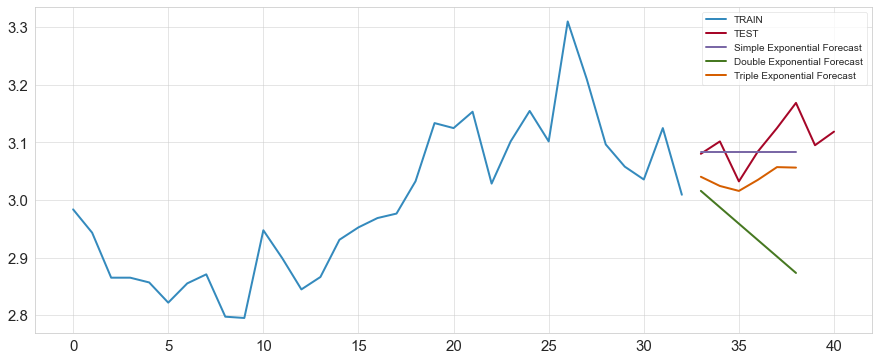

In [13]:

input_folder = "C:/Users/GCV/Documents/MAS/Project AR/con_output/test/"
output_folder = "C:/Users/GCV/Documents/MAS/Project AR/cust_output/"

for filename in os.listdir(input_folder):
    if filename.endswith(".xlsx"):
        print(filename)
        file_path = os.path.join(input_folder, filename)

        final_data = future_prediction(file_path)
        
        final_data.to_excel(os.path.join(output_folder, filename))

        #print(file_path)
        #print(final_data)


In [191]:

#creating dashboard back end excel file(adding 2022(rfm,cluster,segmentation) and 2023(rfm,cluster,segmentation) columns)

import pandas as pd
import warnings
warnings.simplefilter("ignore")


# read in the data from an Excel file
df = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/2nd_final_output/Consolidated_file_sorted.xlsx")

# extract week numbers as integers
df['Week_num'] = df['Week'].str.extract(r'(\d+)').astype(int)

# identify weeks in 2022 and 2023
week_22 = [str(w).zfill(2) for w in range(16, 52)]
week_23 = [str(w).zfill(2) for w in range(1, 16)] + [str(w).zfill(2) for w in range(52, 53)]

# subset the data to include only weeks in 2022 and 2023
df_2022 = df[df['Week_num'].isin(range(16, 52))]
df_2023 = df[df['Week_num'].isin(range(1, 16)) | df['Week_num'].isin([52])] #alert on this is somewhat hard coding part

# create new columns for 2022 and 2023 weeks
df_2022['2022 Week'] = df_2022['Week']
df_2023['2023 Week'] = df_2023['Week']

# concatenate the two subsets back into the original DataFrame
df = pd.concat([df_2022, df_2023], ignore_index=True)



# Create new columns with empty values
df['RFM_Score_2022'] = ''
df['Customer_segment_2022'] = ''
df['Cluster_2022'] = ''



# Create a boolean mask for the rows where "2022 Week" is not null
mask = ~df['2022 Week'].isnull()

# Assign the values to the new columns using the mask
df.loc[mask, 'RFM_Score_2022'] = df.loc[mask, 'RFM_Score']
df.loc[mask, 'Customer_segment_2022'] = df.loc[mask, 'Customer_segment']
df.loc[mask, 'Cluster_2022'] = df.loc[mask, 'Cluster']



df['RFM_Score_2023'] = ''
df['Customer_segment_2023'] = ''
df['Cluster_2023'] = ''



# Create a boolean mask for the rows where "2022 Week" is not null
mask = ~df['2023 Week'].isnull()

# Assign the values to the new columns using the mask
df.loc[mask, 'RFM_Score_2023'] = df.loc[mask, 'RFM_Score']
df.loc[mask, 'Customer_segment_2023'] = df.loc[mask, 'Customer_segment']
df.loc[mask, 'Cluster_2023'] = df.loc[mask, 'Cluster']



# print the result
print(df.head())
print(df.tail())

# save the result to a new Excel file
df.to_excel(r"C:/Users/GCV/Documents/MAS/Project AR/2nd_final_output/Actual_values.xlsx", index=False)


   Unnamed: 0                             Customer  RFM_Score  \
0           0     AMAZON ESSENTIAL - SPOTTED ZEBRA   3.108757   
1           1       AMERICAN DESIGNER FASHION, S.A   2.112688   
2           2  ASCO GENERAL SUPPLIES (FAR EAST)LTD   2.904967   
3           3      Abercrombie & Fitch Trading Co.   2.618711   
4           4                                Aerie   3.124307   

               Customer_segment Week  Cluster    Monetory  Week_num 2022 Week  \
0  Moderate Overdue - 2<RFM<3.5  W16        3    11178.00        16       W16   
1  Moderate Overdue - 2<RFM<3.5  W16        3    14750.15        16       W16   
2  Moderate Overdue - 2<RFM<3.5  W16        3  1503457.40        16       W16   
3  Moderate Overdue - 2<RFM<3.5  W16        3   209184.39        16       W16   
4  Moderate Overdue - 2<RFM<3.5  W16        3  2364214.49        16       W16   

  2023 Week RFM_Score_2022         Customer_segment_2022 Cluster_2022  \
0       NaN       3.108757  Moderate Overdue - 2<

In [189]:
import os
import glob
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt


def process_input_file(file_path):
    # read the input file as a DataFrame with temporary header names
    df = pd.read_excel(file_path, header=0)
    df1= df[['Predicted Values', 'Future Predictions Simple ES','Future Predictions Double ES', 'Future Predictions Triple ES']]
    df1 = df1.fillna('')
    df_sMAPE =df[['sMAPE Simple ES','sMAPE Double ES','sMAPE Triple ES']]
    # set temporary header names
    temp_header = ["Column" + str(i) for i in range(df1.shape[1])]
    df1.columns = temp_header
    
    new_df = pd.DataFrame()
    
    for col in df1.columns:
        # split the 'Actual Values' column into separate columns
        df_actual = df1[col].str.split('\n', expand=True)
        df_actual = df_actual.transpose()
        df_actual = df_actual.drop(index=(df_actual.shape[0]-1))
        
        new_df = pd.concat([new_df, df_actual], axis=1, ignore_index=False)
    
    # reset header names to None
    #new_df.columns = None
    new_df.columns = ['Predicted Values', 'Future Predictions Simple ES','Future Predictions Double ES', 'Future Predictions Triple ES']

    # reset index
    new_df = new_df.reset_index(drop=True)
    #split multi line text in single values to separate columns
    new_df = new_df.apply(lambda x: x.str.split())

    # extract the second value from each cell in all columns(ex- 33 2.321 to 2.321)
    new_df = new_df.apply(lambda x: x.str[1])
    
    #file_name = os.path.basename(file_path)
    file_name, file_extension = os.path.splitext(os.path.basename(file_path))

    #file_name = file_path.split('.')[0]
    # create a new column with the file name
    new_df['customer'] = file_name

    
    
    final_df = pd.concat([new_df, df_sMAPE], axis=1, ignore_index=False)
    final_df = final_df[['customer','Predicted Values', 'Future Predictions Simple ES','Future Predictions Double ES', 'Future Predictions Triple ES','sMAPE Simple ES', 'sMAPE Double ES', 'sMAPE Triple ES']]
    final_df = final_df.fillna(0)
    
    #selecting minimum sMAPE and get best predicted values
    pred_cols  = final_df[['Future Predictions Simple ES','Future Predictions Double ES', 'Future Predictions Triple ES']]
    sMAPE_cols = final_df[['sMAPE Simple ES', 'sMAPE Double ES', 'sMAPE Triple ES']]
   
    #sort cloumn names in sMAPEs
    sorted_columns = sMAPE_cols.mean().sort_values().index.tolist()
    
    
    # create an empty list to store the column names
    dup_col = []

    # iterate over the columns
    for col in pred_cols.columns:
        # check if all values in the column are duplicates
        if pred_cols[col].duplicated().all():
            # add the column name to the list
            dup_col.append(col)
    
       
        for i, col in enumerate(sorted_columns):
            
            if col == 'sMAPE Triple ES':
                if col in dup_col:
                    break
                else:
                    best_col = 'Future Predictions Triple ES'
            elif col == 'sMAPE Double ES':
                if col in dup_col:
                    break
                else:
                    best_col = 'Future Predictions Double ES'
            else:
                if col in dup_col:
                    break
                else:
                    best_col = 'Future Predictions Simple ES'

                    
    final_df['best predict'] = final_df[best_col]             
    final_df['sMAPE'] = sMAPE_cols[sorted_columns[0]]
    return final_df




In [190]:
input_folder = "C:/Users/GCV/Documents/MAS/Project AR/cust_output/"
output_folder = "C:/Users/GCV/Documents/MAS/Project AR/cust_predictions/test/"

# Set the file pattern you want to match, for example, all files with ".txt" extension

file_pattern= input_folder + "*.xlsx"

# Use glob function to get the file names that match each file pattern
file_names = glob.glob(file_pattern)

# Loop through each file name and process the corresponding Excel file
for file_name in file_names:
    final_data = process_input_file(file_name)
    #final_data2 = add_week_column(file_name)
   
    #final_data = pd.concat([final_data2,final_data1], axis=1).reset_index(drop=True)
    
    
    output_file_name = os.path.join(output_folder, os.path.basename(file_name))
    output_file_name = os.path.splitext(output_file_name)[0] + ".xlsx"
    final_data.to_excel(output_file_name, index = False)    
    
    
print("done")

done


In [151]:
import pandas as pd
import numpy as np

input_folder = "C:/Users/GCV/Documents/MAS/Project AR/cust_predictions/test/"
output_folder= "C:/Users/GCV/Documents/MAS/Project AR/cust_predictions/test/final_df/"

# Set the file pattern you want to match, for example, all files with ".txt" extension

file_pattern= input_folder + "*.xlsx"

# Use glob function to get the file names that match each file pattern
file_names = glob.glob(file_pattern)

#print(file_names)
for file in file_names:
    df = pd.read_excel(file)

    df_con = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/2nd_final_output/updated_consolidate.xlsx")


    first_value = df_con['Week_num'].iloc[1]
    last_value = df_con['Week_num'].iloc[-1]

    # calculate the starting week number
    starting_week = last_value -6 + 52
   

    # define the range of values to repeat
    start_val = 1
    end_val = 51
    repeat_val = starting_week

    # calculate the number of times to repeat the range
    num_rows =  len(df.index)
    num_repeats = int(np.ceil(num_rows / (end_val - start_val + 1)))

    # create the array of values to repeat
    vals_to_repeat = np.concatenate((np.arange(start_val, end_val+1),np.arange(repeat_val, end_val+1)))

    # repeat the array the necessary number of times
    repeated_vals = np.tile(vals_to_repeat, num_repeats)[:num_rows]
    # add the repeated values to the new column in the dataframe
    week_vals = [(starting_week + i) % 51 or 51 for i in range(num_rows)]
    df.insert(loc=0, column='Week', value=week_vals)
    last_w = df['Week'].iloc[-1]
    list_week = []
    for i in range (4):
        list_week.append(last_w + i+1)

    df_w = pd.DataFrame({'Week': list_week})
     
    df = pd.concat([df,df_w], axis =0).reset_index(drop = True)
    df['Week num'] = 'W' + df['Week'].astype(str)
    
    
    customer_name = df['customer'].iloc[1]

    # Replace the missing values in the "customer" column with the customer name
    df['customer'] = df['customer'].fillna(customer_name)
    # print(customer_name)
    # print(df)
    
    df['Future_prediction'] = ''
    df.loc[6:, 'Future_prediction'] = df.loc[:3, 'best predict'].values
    
    df = df.fillna(0)
    output_file_name = os.path.join(output_folder, os.path.basename(file))
    output_file_name = os.path.splitext(output_file_name)[0] + ".xlsx"
    
    
    df.to_excel(output_file_name, index = False)   
    
    
print("done")

done


In [152]:
import pandas as pd

#input_folder = "C:/Users/GCV/Documents/MAS/Project AR/cust_output/"
input_folder =  "C:/Users/GCV/Documents/MAS/Project AR/cust_predictions/test/final_df/"
output_file = "C:/Users/GCV/Documents/MAS/Project AR/merged_predictions.xlsx"

# Set the file pattern you want to match, for example, all files with ".txt" extension

file_pattern= input_folder + "*.xlsx"

# Use glob function to get the file names that match each file pattern
file_names = glob.glob(file_pattern)


# create empty dataframe to store merged data
merged_df = pd.DataFrame()

# loop through customer files and merge data
for filename in file_names:   # replace file_list with the list of file names in your folder
    df = pd.read_excel(filename)   # read in each file as a data frame
    merged_df = pd.concat([merged_df, df], ignore_index=True)   # append each data frame to the merged data frame

    
    
merged_df['Week'] , merged_df['Week num'] = merged_df['Week num'], merged_df['Week']
# print the merged data frame
print(merged_df.columns)

merged_df.to_excel(output_file)

Index(['Week', 'customer', 'Predicted Values', 'Future Predictions Simple ES',
       'Future Predictions Double ES', 'Future Predictions Triple ES',
       'sMAPE Simple ES', 'sMAPE Double ES', 'sMAPE Triple ES', 'best predict',
       'Week num', 'Future_prediction'],
      dtype='object')


In [192]:
# #creating dashboard back end excel file

# import pandas as pd
# import warnings
# warnings.simplefilter("ignore")


# # read in the data from an Excel file
# df = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/2nd_final_output/Consolidated_file_sorted.xlsx")

# # extract week numbers as integers
# df['Week_num'] = df['Week'].str.extract(r'(\d+)').astype(int)

# # identify weeks in 2022 and 2023
# week_22 = [str(w).zfill(2) for w in range(16, 52)]
# week_23 = [str(w).zfill(2) for w in range(1, 16)] + [str(w).zfill(2) for w in range(52, 53)]

# # subset the data to include only weeks in 2022 and 2023
# df_2022 = df[df['Week_num'].isin(range(16, 52))]
# df_2023 = df[df['Week_num'].isin(range(1, 16)) | df['Week_num'].isin([52])]

# # create new columns for 2022 and 2023 weeks
# df_2022['2022 Week'] = df_2022['Week']
# df_2023['2023 Week'] = df_2023['Week']

# # concatenate the two subsets back into the original DataFrame
# df = pd.concat([df_2022, df_2023], ignore_index=True)



# # Create new columns with empty values
# df['RFM_Score_2022'] = ''
# df['Customer_segment_2022'] = ''
# df['Cluster_2022'] = ''



# # Create a boolean mask for the rows where "2022 Week" is not null
# mask = ~df['2022 Week'].isnull()

# # Assign the values to the new columns using the mask
# df.loc[mask, 'RFM_Score_2022'] = df.loc[mask, 'RFM_Score']
# df.loc[mask, 'Customer_segment_2022'] = df.loc[mask, 'Customer_segment']
# df.loc[mask, 'Cluster_2022'] = df.loc[mask, 'Cluster']



# df['RFM_Score_2023'] = ''
# df['Customer_segment_2023'] = ''
# df['Cluster_2023'] = ''



# # Create a boolean mask for the rows where "2022 Week" is not null
# mask = ~df['2023 Week'].isnull()

# # Assign the values to the new columns using the mask
# df.loc[mask, 'RFM_Score_2023'] = df.loc[mask, 'RFM_Score']
# df.loc[mask, 'Customer_segment_2023'] = df.loc[mask, 'Customer_segment']
# df.loc[mask, 'Cluster_2023'] = df.loc[mask, 'Cluster']

# # if 'Unnamed: 0' in df.columns:
# #     df = df.drop(columns=['Unnamed: 0'], inplace=True)


# # print the result
# print(df.head())
# print(df.tail())

# # save the result to a new Excel file
# df.to_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Actual_values.xlsx", index=False)


In [160]:
#getting filter values based on weeek number in predictions
import pandas as pd

df = pd.read_excel("C:/Users/GCV/Documents/MAS/Project AR/merged_predictions.xlsx")
#df.head()

df_con = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/2nd_final_output/Actual_values.xlsx")


first_value = df_con['Week_num'].iloc[1]
last_value = df_con['Week_num'].iloc[-1]

# calculate the starting week number
starting_week = last_value -6 + 52


start_val = 1
end_val = 51
repeat_val = starting_week

# calculate the number of times to repeat the range
num_rows =  len(df.index)
num_repeats = int(np.ceil(num_rows / (end_val - start_val + 1)))

# create the array of values to repeat
vals_to_repeat = np.concatenate((np.arange(start_val, end_val+1),np.arange(repeat_val, end_val+1)))

# repeat the array the necessary number of times
repeated_vals = np.tile(vals_to_repeat, num_repeats)[:num_rows]
# add the repeated values to the new column in the dataframe
week_vals = [(starting_week + i) % 51 or 51 for i in range(num_rows)]

pred_starting_week = (starting_week+6) % 51

print(pred_starting_week)
week_filter = [0]*4
for i in range(4):
    week_filter[i]= pred_starting_week +i

    
#print(week_filter)

# create an empty list to store the filtered DataFrames
df_list = []

# loop over each value in week_list and filter the DataFrame
for week in week_filter:
    df_filtered = df[df['Week num'] == week]
    df_list.append(df_filtered)

# concatenate all the DataFrames in df_list into one DataFrame
df_combined = pd.concat(df_list)


df_to_actual =df_combined[['Week', 'customer','Week num', 'Future_prediction']]
print(df_to_actual)

df_to_actual.to_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Actual_vales_merge.xlsx", index=False)
# #df_to_actual =merged_df[['Week', 'customer','Week num', 'Future_prediction']]


6
    Week                          customer  Week num  Future_prediction
6     W6   Abercrombie & Fitch Trading Co.         6           2.706649
16    W6                             Aerie         6           1.980229
26    W6  AMAZON ESSENTIAL - SPOTTED ZEBRA         6           3.534572
36    W6                         Amazon UK         6           3.520448
46    W6    AMERICAN DESIGNER FASHION, S.A         6           2.838447
..   ...                               ...       ...                ...
249   W9                 Puritas (Pvt) Ltd         9           3.623391
259   W9                  PVH ASIA LIMITED         9         -17.883659
269   W9                        Speedo PVH         9           2.588811
279   W9                  Summersalt, Inc.         9           3.499887
289   W9   The Colombo Fashion WSwim Pvt L         9           2.702362

[116 rows x 4 columns]


In [161]:
#concat Actual and prediction data frames in to one df

In [169]:
# import pandas as pd 


# df_actual = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Actual_values.xlsx")

# df_predict = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/test_merge.xlsx")


# df_actual['Future_prediction'] = ''

# if 'Unnamed: 0' in df.columns:
#     df_actual.drop(columns=['Unnamed: 0'], inplace=True)



# df_predict.rename(columns={'customer': 'Customer'}, inplace=True)
# df_predict.rename(columns={'Week num': 'Week_num'}, inplace=True)

# #creating null column because of concat
# df_predict[[ 'RFM_Score', 'Customer_segment','Cluster', 'Monetory', '2022 Week', '2023 Week','RFM_Score_2022', 'Customer_segment_2022', 'Cluster_2022','RFM_Score_2023', 'Customer_segment_2023', 'Cluster_2023']] = None

# df_predicts = df_predicts[['Customer', 'RFM_Score', 'Customer_segment', 'Week', 'Cluster',
#        'Monetory', 'Week_num', '2022 Week', '2023 Week', 'RFM_Score_2022',
#        'Customer_segment_2022', 'Cluster_2022', 'RFM_Score_2023',
#        'Customer_segment_2023', 'Cluster_2023', 'Future_prediction']]
# common_cols = list(set(df_actual.columns) & set(df_predict.columns))
# # df_actual = pd.concat([df_actual[common_cols], df_predict[common_cols]], axis=0)

# df_actual = pd.concat([df_actual, df_predicts], axis=0)


# # print(df_actual.columns)
# print(df_predict.columns)
# #print()

# print(common_cols)



# #print(df_predict.columns)
# # df_actual['Future_prediction'] = ''
# # df2 = pd.DataFrame(df_predict['Week'])
# # df3 = pd.DataFrame(df_predict['customer'])
# # df4 = pd.DataFrame(df_predict['Week num'])
# # df5 = pd.DataFrame(df_predict['Future_prediction'])


# # df_actual = pd.concat([df_actual.set_index('Week'), df2.set_index('Week')], axis=0, join='inner').reset_index()
# # df_actual = pd.concat([df_actual.set_index('customer'), df3.set_index('customer')], axis=0, join='inner').reset_index()
# # df_actual = pd.concat([df_actual.set_index('Week num'), df4.set_index('Week num')], axis=0, join='inner').reset_index()
# # df_actual = pd.concat([df_actual.set_index('Future_prediction'), df4.set_index('Future_prediction')], axis=0, join='inner').reset_index()


# #merged_df =  pd.concat([df_actual[['Week', 'customer', 'Week num', 'Future_prediction']], df_predict[['Week', 'customer', 'Week num', 'Future_prediction']]], axis=0).reset_index(drop=True)

# df_actual.to_excel(r"C:/Users/GCV/Documents/MAS/Project AR/pbi_file.xlsx")

In [171]:
import pandas as pd 

df_actual = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Actual_values.xlsx")
df_predict = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Actual_values_merge.xlsx")

df_actual['Future_prediction'] = ''

#chechk always if Unnamed: 0 column exists if its availble drop it(if it availble its harder to concat dfs)
if 'Unnamed: 0' in df.columns:
    df_actual.drop(columns=['Unnamed: 0'], inplace=True)

df_predict.rename(columns={'customer': 'Customer'}, inplace=True)
df_predict.rename(columns={'Week num': 'Week_num'}, inplace=True)

# creating null column because of concat
df_predict[['RFM_Score', 'Customer_segment', 'Cluster', 'Monetory', '2022 Week', '2023 Week', 'RFM_Score_2022', 'Customer_segment_2022', 'Cluster_2022', 'RFM_Score_2023', 'Customer_segment_2023', 'Cluster_2023']] = None

#common_cols = list(set(df_actual.columns) & set(df_predict.columns))
df_actual = pd.concat([df_actual, df_predict], axis=0)

# print(df_actual.columns)
# print(df_predict.columns)
# print(common_cols)

df_actual.to_excel(r"C:/Users/GCV/Documents/MAS/Project AR/pbi_file.xlsx")
